In [3]:
import statistics
import json
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

nltk.download("stopwords")
nltk.download("wordnet")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/julienh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/julienh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
with open('/Users/julienh/Desktop/McGillWork/PainLexicon/chronic_reddit_scraper/posts_data_20250110_152846.json', 'r') as file:
    data = json.load(file)

for post in data[:3]:
    print(post)
    print("-" * 20)

{'title': 'Speech dictation is so horrible ', 'author': 'Genkikiwi', 'created_timestamp': '2024-12-30T00:52:57.936000+0000', 'score': '3', 'upvote_ratio': 0, 'content': ':/ i understand the application of it is likely for more formal writings, but it’s so bad on my iPhone.. i feel really alienated among my friends because when my pain flares up i start typing all disjointed and not like myself… if you’re anything like me and housebound with lots of online friends, you know how important a tiny thing like your typing style is!! And there’s so many errors I have to go through and fix manually, because doing it with voice control is too difficult.  I’ve been using it for years now and it’s always been obnoxious..', 'post_id': 't3_1hpat85', 'comments': [{'thing_id': 't1_m4ivacc', 'depth': 0, 'parent_id': None, 'author': 'BeeBaguette', 'text': "this is probably the most relatable thing I've seen all day! yeah it's so annoying and when it spews out the most random words that are nowhere near

In [5]:
"""
Extracts and concatenates text from posts, comments, and replies.

This code iterates through a list of post dictionaries, extracting the title,
content, and all associated comments and replies. It then concatenates these
text elements into a single string for each post and stores them in a list.
"""
posts_texts = []
for post in data:
    post_text = post["title"] + " " + post["content"]
    for comment in post["comments"]:
        post_text += " " + comment["text"]
        for reply in comment["replies"]:
            post_text += " " + reply["text"]
    posts_texts.append(post_text)

print(posts_texts[0])

Speech dictation is so horrible  :/ i understand the application of it is likely for more formal writings, but it’s so bad on my iPhone.. i feel really alienated among my friends because when my pain flares up i start typing all disjointed and not like myself… if you’re anything like me and housebound with lots of online friends, you know how important a tiny thing like your typing style is!! And there’s so many errors I have to go through and fix manually, because doing it with voice control is too difficult.  I’ve been using it for years now and it’s always been obnoxious.. this is probably the most relatable thing I've seen all day! yeah it's so annoying and when it spews out the most random words that are nowhere near what I'm trying to say it's just so frustrating :/hope you're having a day with less pain than usual OP :)


In [13]:
"""
Preprocesses text data by removing URLs, usernames, subreddit mentions,
punctuation, and special characters. It also converts text to lowercase,
lemmatizes words, and removes stop words.
"""

# Custom words to ignore
custom_stop_words = {
    'im', 'ive', 'dont', 'cant', 'like', 'would', 'could', 'should',
    'thats', 'wasnt', 'didnt', 'doesnt', 'isnt', 'aint',
    'gonna', 'wanna', 'gotta', 'just', 'really', 'get', 'got',
    'even', 'also', 'much', 'many', 'well'
}

stop_words = set(stopwords.words("english")).union(custom_stop_words)
lemmatizer = WordNetLemmatizer()


def preprocess_text(text):
    """
    Cleans and preprocesses a given text string.

    Args:
        text (str): The input text string.

    Returns:
        str: The preprocessed text string.
    """    
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"u/\S+", "", text)  # Remove usernames
    text = re.sub(r"r/\S+", "", text)  # Remove subreddit mentions
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove punctuation and special characters
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(words)

cleaned_posts_texts = [preprocess_text(post_text) for post_text in posts_texts]

In [14]:
# save cleaned posts texts to file
with open('cleaned_posts_texts.txt', 'w') as file:
    for text in cleaned_posts_texts:
        file.write(text + "\n")


In [67]:
# lets get some simple statistics 
print(f"Number of posts: {len(cleaned_posts_texts)}")
print(f"Number of unique words: {len(set(word for text in cleaned_posts_texts for word in text.split()))}")
print(f"Number of words: {sum(len(text.split()) for text in cleaned_posts_texts)}")

# Calculate total number of tokens (including duplicates)
total_tokens = sum(len(nltk.word_tokenize(text)) for text in cleaned_posts_texts)
print(f"Number of tokens: {total_tokens}")

Number of posts: 1786
Number of unique words: 37172
Number of words: 616733
Number of tokens: 617056


In [16]:
# number of words per post analysis
word_counts = [len(text.split()) for text in cleaned_posts_texts]
print(f"Average words per post: {sum(word_counts) / len(word_counts)}")
print(f"Median words per post: {statistics.median(word_counts)}")
print(f"Longest post (word count): {max(word_counts)}")
print(f"Shortest post (word count): {min(word_counts)}")


Average words per post: 345.3152295632699
Median words per post: 206.0
Longest post (word count): 7299
Shortest post (word count): 0


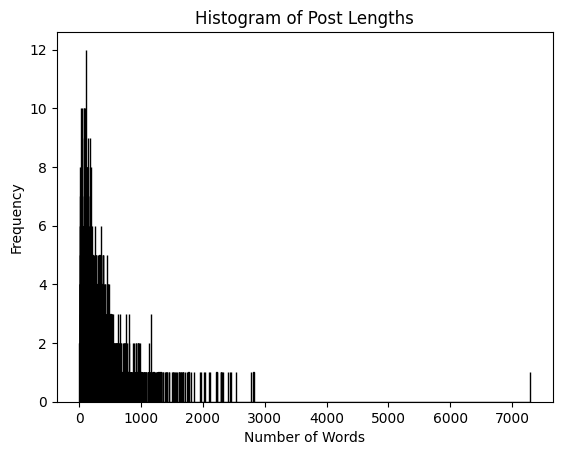

In [17]:
# create a histogram of word lengths
plt.hist(word_counts, bins=range(1, max(word_counts) + 1), edgecolor='black')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Histogram of Post Lengths')
plt.show()


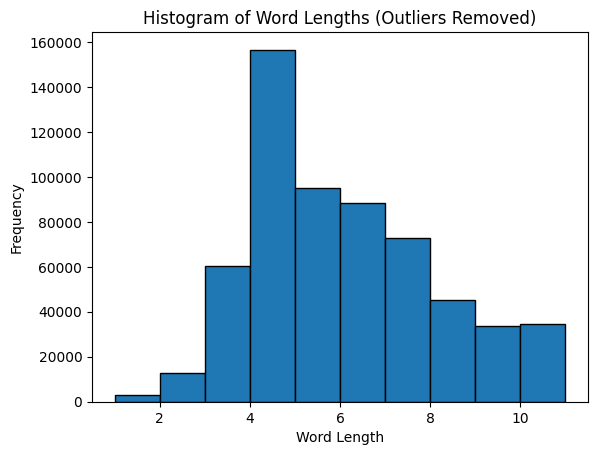

In [18]:
def plot_word_length_histogram(cleaned_posts_texts):
    """
    Generates and displays a histogram of word lengths from a list of cleaned text posts,
    removing outliers based on the IQR.

    Args:
        cleaned_posts_texts (list): A list of strings, where each string is a cleaned text post.
    """
    # concatenate all the posts texts into a single string
    all_text = " ".join(cleaned_posts_texts)
    # create a histogram of word lengths    
    word_lengths = [len(word) for word in all_text.split()]

    # Calculate the IQR
    Q1 = statistics.quantiles(word_lengths, n=4)[0]
    Q3 = statistics.quantiles(word_lengths, n=4)[2]
    IQR = Q3 - Q1

    # Define bounds for outlier removal
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out outliers
    filtered_word_lengths = [length for length in word_lengths if lower_bound <= length <= upper_bound]


    plt.hist(filtered_word_lengths, bins=range(1, max(filtered_word_lengths) + 1), edgecolor='black')
    plt.xlabel('Word Length')
    plt.ylabel('Frequency')
    plt.title('Histogram of Word Lengths (Outliers Removed)')
    plt.show()

plot_word_length_histogram(cleaned_posts_texts)


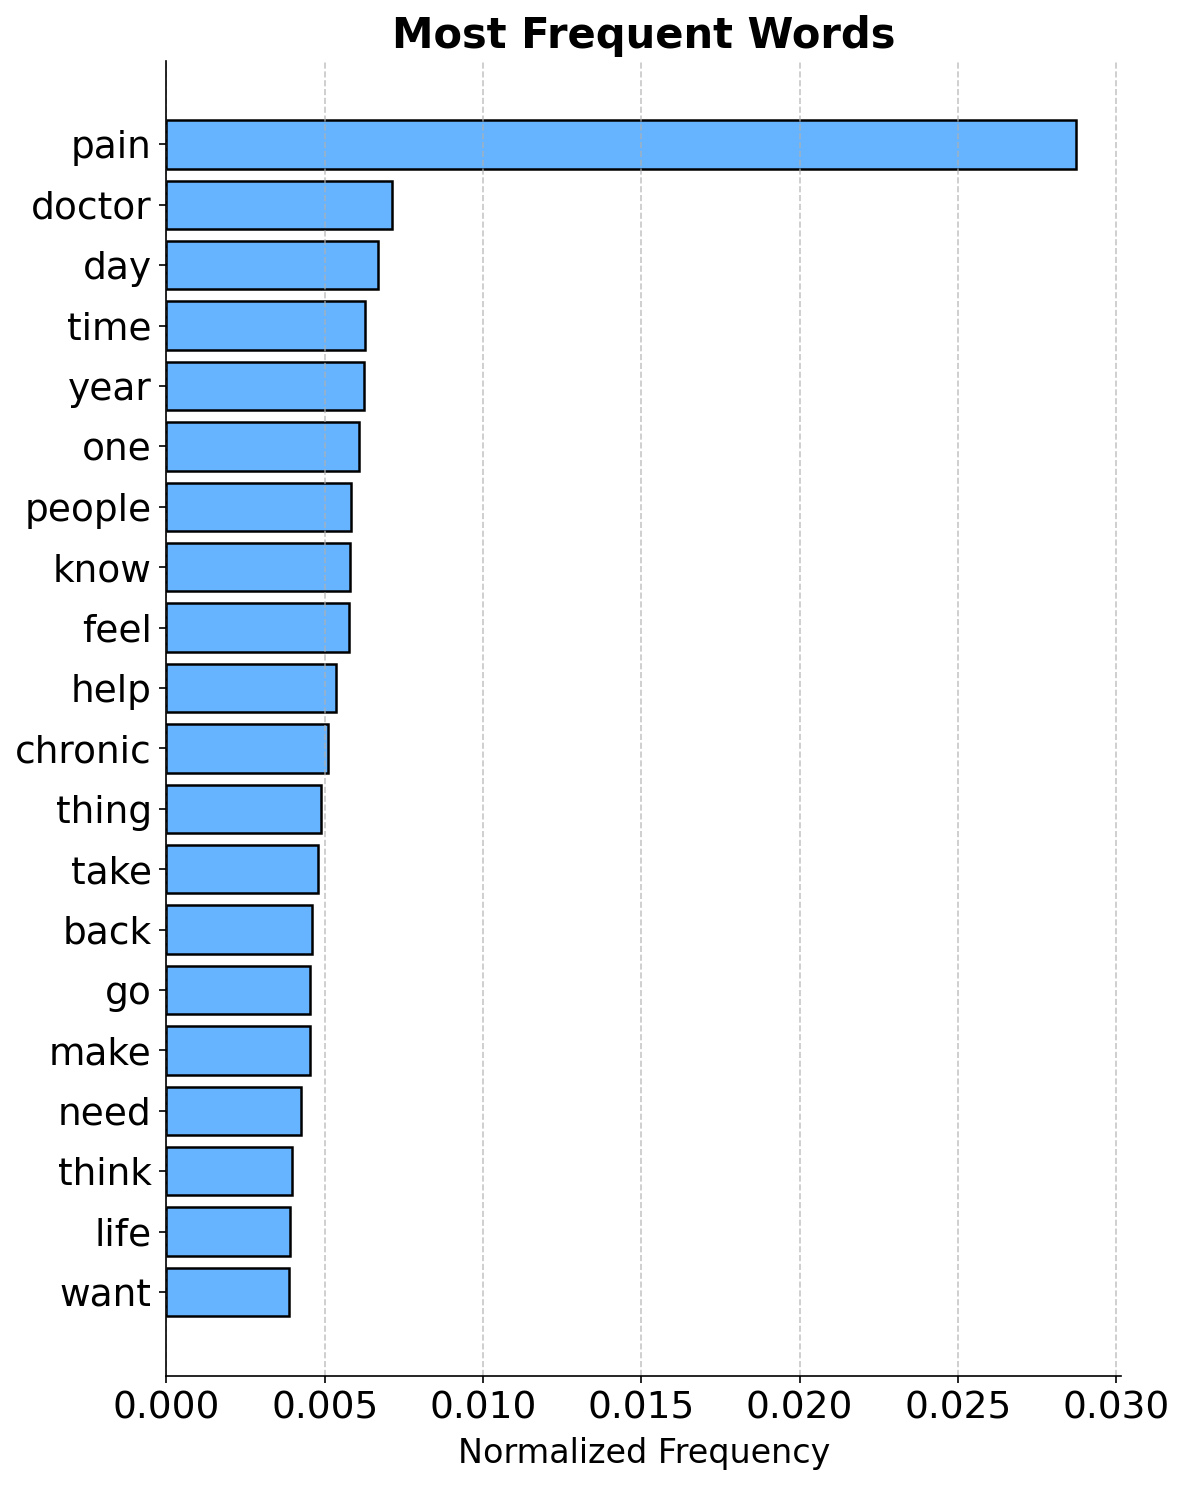

In [145]:
def plot_top_words(cleaned_texts, n=20):
    """
    Creates a vertical bar chart of the n most frequent words, styled to match the term frequency plot,
    with words ordered by frequency in descending order.
    """
    # Get word frequencies
    words = ' '.join(cleaned_texts).split()
    word_counts = Counter(words)
    
    # Normalize frequencies
    total_words = len(words)
    word_freq = [(word, count / total_words) for word, count in word_counts.most_common(n)]
    
    # Prepare data for plotting
    words, frequencies = zip(*word_freq)
    
    # Create vertical bar plot
    plt.figure(figsize=(8, 10), dpi=150)
    
    # Reverse the order of words and frequencies for descending order
    words = list(words)[::-1]
    frequencies = list(frequencies)[::-1]
    
    ax = plt.barh(words, frequencies, color='#66b3ff', edgecolor='black', linewidth=1.2)
    plt.title('Most Frequent Words', fontsize=20, fontweight='bold')
    plt.xlabel('Normalized Frequency', fontsize=16, labelpad=5)
    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig("/Users/julienh/Desktop/McGillWork/PainLexicon/chronic_reddit_scraper/visualizations/top_words.png")
    plt.show()

plot_top_words(cleaned_posts_texts)

Should get rid of words like: im, ive - subject 

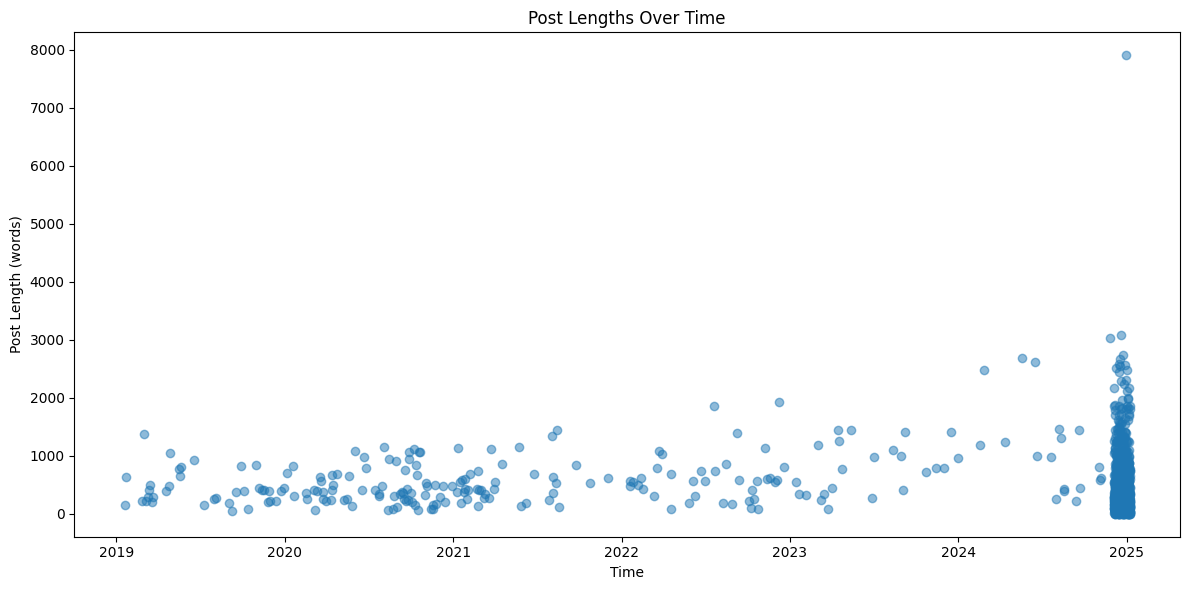

In [9]:
def plot_post_lengths_over_time(data):
    """
    Creates a scatter plot of post lengths over time.
    """
    # Extract timestamps and lengths
    timestamps = [pd.to_datetime(post['created_timestamp']) for post in data]
    lengths = [len(text.split()) for text in cleaned_posts_texts]
    
    plt.figure(figsize=(12, 6))
    plt.scatter(timestamps, lengths, alpha=0.5)
    plt.xlabel('Time')
    plt.ylabel('Post Length (words)')
    plt.title('Post Lengths Over Time')
    plt.tight_layout()
    plt.show()

plot_post_lengths_over_time(data)


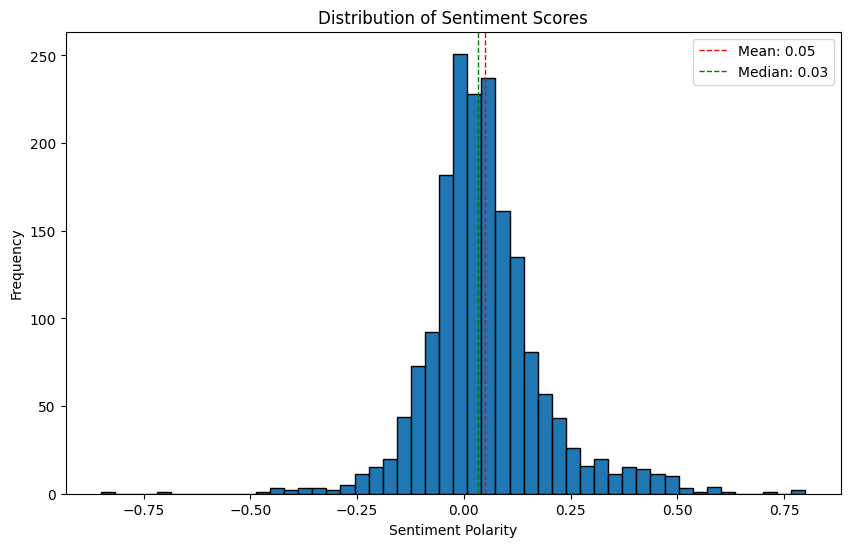

In [20]:
from textblob import TextBlob
import numpy as np

def plot_sentiment_distribution(texts):
    """
    Creates a histogram of sentiment polarity scores, with mean and median lines.
    """
    sentiments = [TextBlob(text).sentiment.polarity for text in texts]
    
    plt.figure(figsize=(10, 6))
    plt.hist(sentiments, bins=50, edgecolor='black')
    
    mean_sentiment = np.mean(sentiments)
    median_sentiment = np.median(sentiments)
    
    plt.axvline(mean_sentiment, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_sentiment:.2f}')
    plt.axvline(median_sentiment, color='g', linestyle='dashed', linewidth=1, label=f'Median: {median_sentiment:.2f}')
    
    plt.xlabel('Sentiment Polarity')
    plt.ylabel('Frequency')
    plt.title('Distribution of Sentiment Scores')
    plt.legend()
    plt.show()

plot_sentiment_distribution(cleaned_posts_texts)

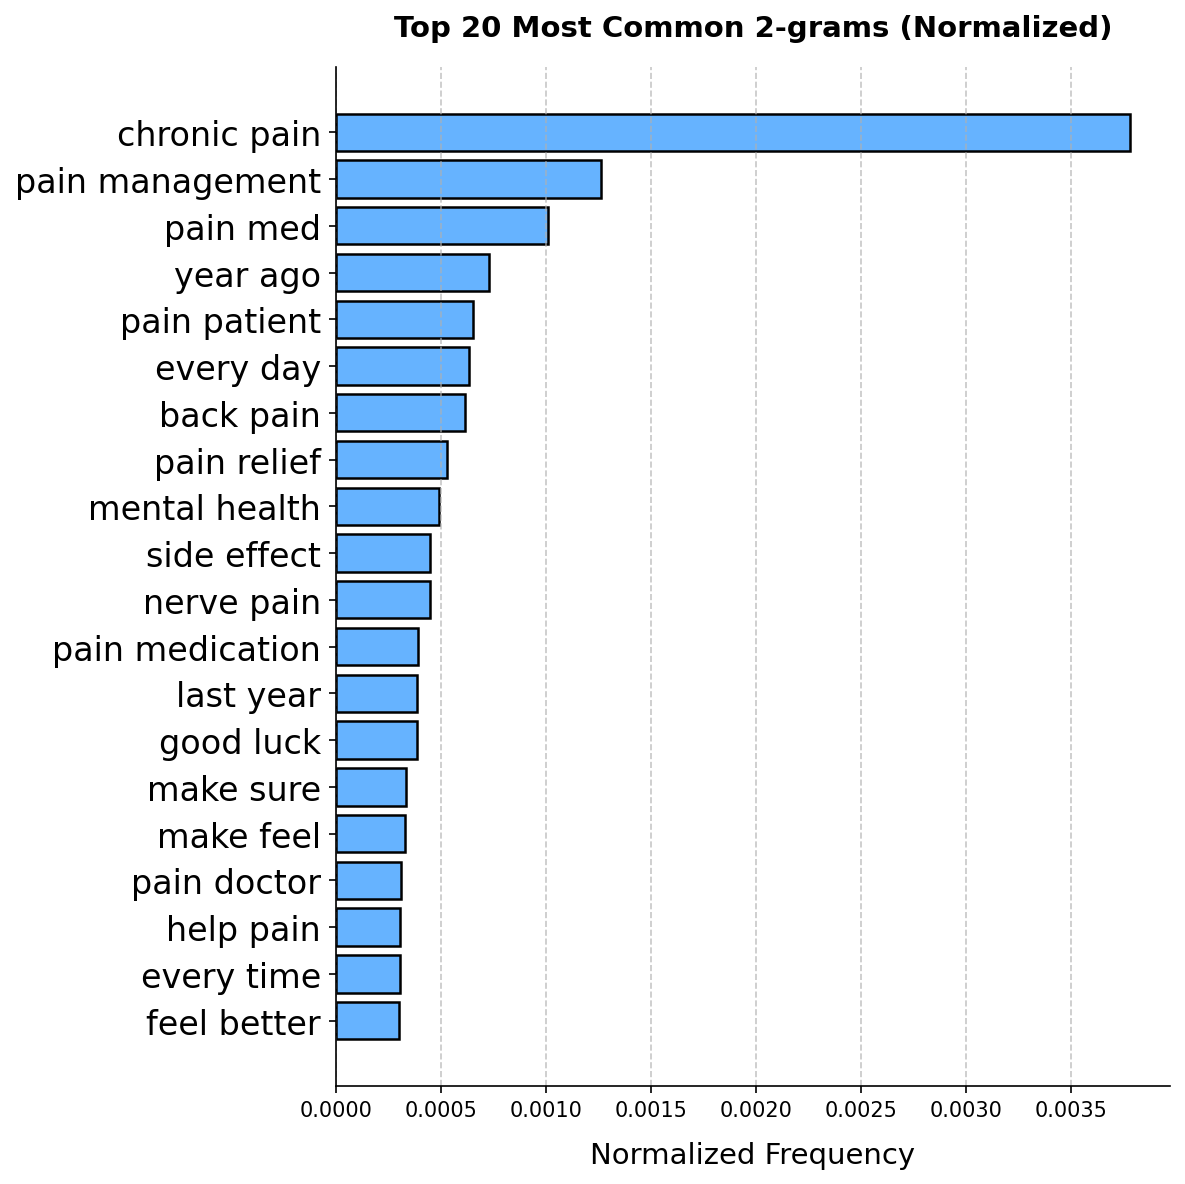

In [176]:
from nltk import ngrams
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

def plot_top_ngrams(texts, n=2, top_k=20):
    """
    Creates a visually appealing horizontal bar chart of the most common n-grams,
    suitable for a scientific poster, using normalized frequencies.
    """
    # Combine all texts and generate n-grams
    words = ' '.join(texts).split()
    n_grams = list(ngrams(words, n))
    total_ngrams = len(n_grams)
    n_gram_counts = Counter(n_grams)
    most_common_ngrams = n_gram_counts.most_common(top_k)
    
    # Prepare data for plotting
    labels = [' '.join(gram) for gram, _ in most_common_ngrams]
    values = [count / total_ngrams for _, count in most_common_ngrams]
    
    # Set a professional color palette
    
    
    # Create horizontal bar plot
    plt.figure(figsize=(8, 8), dpi=150)  # Increased dpi for better resolution
    ax = plt.barh(range(len(labels)), values, color='#66b3ff', edgecolor='black', linewidth=1.2) # Use a more scientific color and add linewidth
    plt.yticks(range(len(labels)), labels, fontsize=16) # Adjust font size
    plt.xlabel('Normalized Frequency', fontsize=14, labelpad=10) # Label padding
    plt.title(f'Top {top_k} Most Common {n}-grams (Normalized)', fontsize=14, fontweight='bold', pad=15) # More descriptive title, bold, and padding
    plt.gca().invert_yaxis()  # Invert y-axis to show most frequent at the top
    plt.grid(axis='x', linestyle='--', alpha=0.7) # Add a subtle grid
    ax = plt.gca()
    ax.spines['top'].set_visible(False) # Remove top spine
    ax.spines['right'].set_visible(False) # Remove right spine
    
    plt.tight_layout()
    plt.show()

plot_top_ngrams(cleaned_posts_texts)

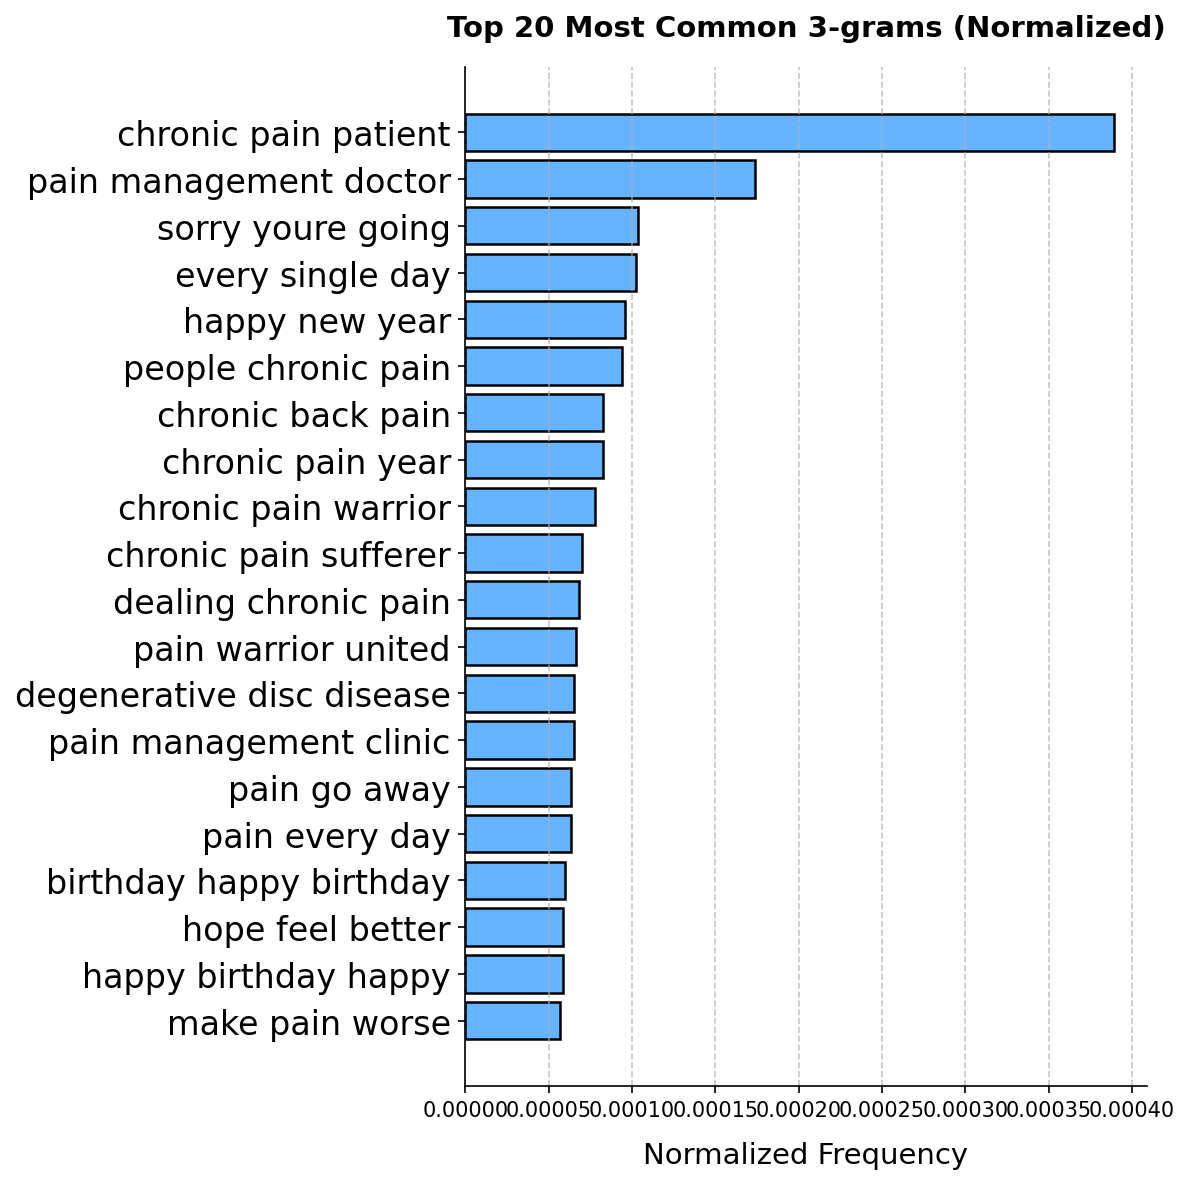

In [177]:
plot_top_ngrams(cleaned_posts_texts, n=3)

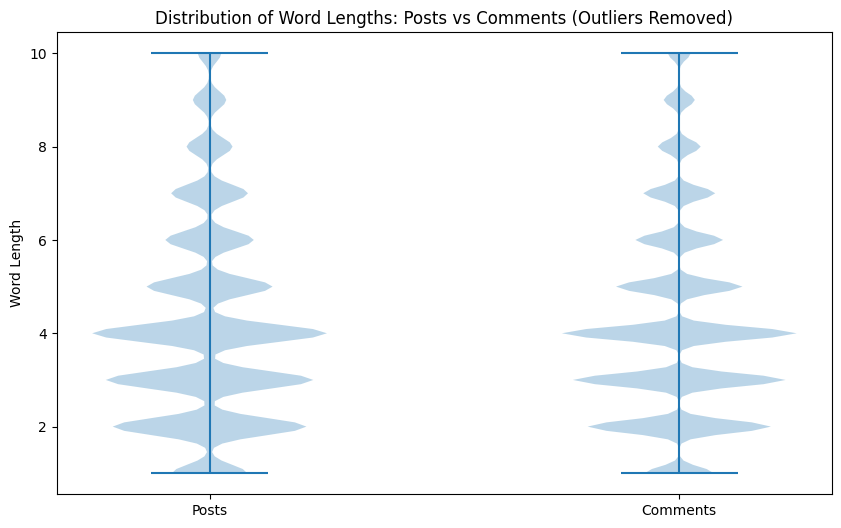

In [23]:
import numpy as np

def plot_word_length_comparison(data):
    """
    Creates a violin plot comparing word lengths in posts vs comments, removing outliers.
    """
    # Separate posts and comments
    post_lengths = []
    comment_lengths = []
    
    for post in data:
        # Get post word lengths
        post_words = (post['title'] + ' ' + post['content']).split()
        post_lengths.extend([len(word) for word in post_words])
        
        # Get comment word lengths
        for comment in post['comments']:
            comment_words = comment['text'].split()
            comment_lengths.extend([len(word) for word in comment_words])
    
    # Function to remove outliers using IQR
    def remove_outliers(lengths):
        q1 = np.percentile(lengths, 25)
        q3 = np.percentile(lengths, 75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        return [length for length in lengths if lower_bound <= length <= upper_bound]

    # Remove outliers
    post_lengths_filtered = remove_outliers(post_lengths)
    comment_lengths_filtered = remove_outliers(comment_lengths)
    
    # Create violin plot
    plt.figure(figsize=(10, 6))
    plt.violinplot([post_lengths_filtered, comment_lengths_filtered])
    plt.xticks([1, 2], ['Posts', 'Comments'])
    plt.ylabel('Word Length')
    plt.title('Distribution of Word Lengths: Posts vs Comments (Outliers Removed)')
    plt.show()

plot_word_length_comparison(data)

In [25]:
# LDA with Gensim
from gensim import corpora
from gensim.models import LdaModel

# Create a dictionary representation of the documents.
dictionary = corpora.Dictionary([text.split() for text in cleaned_posts_texts])
# Filter out extremes (similar to the min_df and max_df parameters in sklearn)
dictionary.filter_extremes(no_below=5, no_above=0.5)  #  
# Create a bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(text.split()) for text in cleaned_posts_texts]
# Train the LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, random_state=42, passes=10)

# Print the topics
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic: {idx} \nWords: {topic}\n")


Topic: 0 
Words: 0.008*"med" + 0.006*"month" + 0.005*"said" + 0.004*"er" + 0.004*"week" + 0.004*"never" + 0.004*"every" + 0.004*"work" + 0.004*"something" + 0.004*"told"

Topic: 1 
Words: 0.009*"med" + 0.008*"drug" + 0.007*"work" + 0.007*"medication" + 0.006*"use" + 0.006*"people" + 0.006*"want" + 0.005*"dose" + 0.005*"opioids" + 0.004*"youre"

Topic: 2 
Words: 0.010*"people" + 0.008*"life" + 0.006*"want" + 0.005*"still" + 0.005*"good" + 0.005*"way" + 0.004*"work" + 0.004*"sorry" + 0.004*"friend" + 0.004*"youre"

Topic: 3 
Words: 0.008*"surgery" + 0.007*"nerve" + 0.005*"muscle" + 0.004*"disc" + 0.004*"work" + 0.004*"issue" + 0.004*"good" + 0.004*"neck" + 0.004*"right" + 0.004*"bad"

Topic: 4 
Words: 0.014*"people" + 0.008*"u" + 0.006*"patient" + 0.006*"love" + 0.006*"want" + 0.005*"see" + 0.005*"happy" + 0.005*"life" + 0.005*"say" + 0.005*"good"



In [26]:
import pyLDAvis.gensim_models
import pyLDAvis

# Assuming you have your trained LDA model (lda_model) and corpus from the previous examples:

# Prepare the visualization data
vis_data = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

# Display the visualization in your browser
#pyLDAvis.display(vis_data)

# You can also save it as an HTML file:
pyLDAvis.save_html(vis_data, 'lda_visualization.html')

## Bert Topic Modelling and Analysis

In [27]:

# BERTopic
from bertopic import BERTopic

topic_model = BERTopic(language="english", calculate_probabilities=False, verbose=True)
topics, _ = topic_model.fit_transform(cleaned_posts_texts)

# Get the topics
topic_model.get_topic_info()
# Print the top 10 most frequent topics
print(topic_model.get_topic_info().head(10))

# Get the top n terms per topic
n_terms = 5
for i in range(len(set(topics)) - 1):  # Exclude outlier topic -1
    print(f"Topic {i}: {topic_model.get_topic(i)[:n_terms]}\n")

2025-01-20 16:32:07,800 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/56 [00:00<?, ?it/s]

2025-01-20 16:32:14,857 - BERTopic - Embedding - Completed ✓
2025-01-20 16:32:14,858 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2025-01-20 16:32:19,363 - BERTopic - Dimensionality - Completed ✓
2025-01-20 16:32:19,364 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-01-20 16:32:19,396 - BERTopic - Cluster - Completed ✓
2025-01-20 16:32:19,398 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-01-20 16:32:19,658 - BERTopic - Representation - Completed ✓


   Topic  Count                             Name  \
0     -1    949            -1_pain_feel_day_time   
1      0     73          0_thank_day_people_feel   
2      1     57          1_kratom_take_drug_pain   
3      2     53              2_knee_pain_hip_leg   
4      3     45       3_doctor_patient_pain_year   
5      4     45     4_job_work_disability_people   
6      5     43      5_disc_spine_surgery_fusion   
7      6     41   6_pharmacy_pharmacist_med_fill   
8      7     40  7_christmas_merry_happy_holiday   
9      8     37      8_opioids_patient_pain_drug   

                                      Representation  \
0  [pain, feel, day, time, doctor, people, one, c...   
1  [thank, day, people, feel, pain, look, time, l...   
2  [kratom, take, drug, pain, mg, dose, opioid, t...   
3  [knee, pain, hip, leg, year, sorry, help, bone...   
4  [doctor, patient, pain, year, medical, one, to...   
5  [job, work, disability, people, disabled, time...   
6  [disc, spine, surgery, fusion, n

In [45]:
from litellm import completion

def generate_topic_name(topic_words):
    """
    Generate a descriptive name for a topic using an LLM.
    
    Args:
        topic_words: List of (word, probability) tuples
        client: LLM client instance
    
    Returns:
        str: A descriptive name for the topic
    """
    # Format the words and probabilities for the prompt
    words_str = ", ".join([f"{word} ({prob:.4f})" for word, prob in topic_words[:10]])
    
    prompt = f"""Given these topic words and their probabilities: {words_str}
    Please generate a short (2-4 words), descriptive name for this topic that captures its main theme.
    Return only the name, nothing else."""
    
    response = completion(model="gpt-4o", messages=[{"role": "user", "content": prompt}], temperature=0.3)
    
    return response.choices[0].message.content.strip()

# Create a dictionary to store topic names
topic_names = {}

# Generate names for each topic
for topic_id in range(len(set(topics)) - 1):  # Exclude outlier topic -1
    topic_words = topic_model.get_topic(topic_id)
    topic_names[topic_id] = generate_topic_name(topic_words)

# Now you can use these names in your visualizations
# For example, updating the topic info display:
topic_info = topic_model.get_topic_info()
topic_info['Name'] = topic_info['Topic'].map(lambda x: topic_names.get(x, 'Outlier Topic'))
print(topic_info[['Topic', 'Name', 'Count']].head(10))

   Topic                       Name  Count
0     -1              Outlier Topic    949
1      0     Gratitude and Emotions     73
2      1     Kratom Pain Management     57
3      2           Knee Pain Issues     53
4      3       Medical Consultation     45
5      4  Employment and Disability     45
6      5      Spinal Surgery Topics     43
7      6          Pharmacy Services     41
8      7     Christmas Celebrations     40
9      8    Opioid Addiction Crisis     37


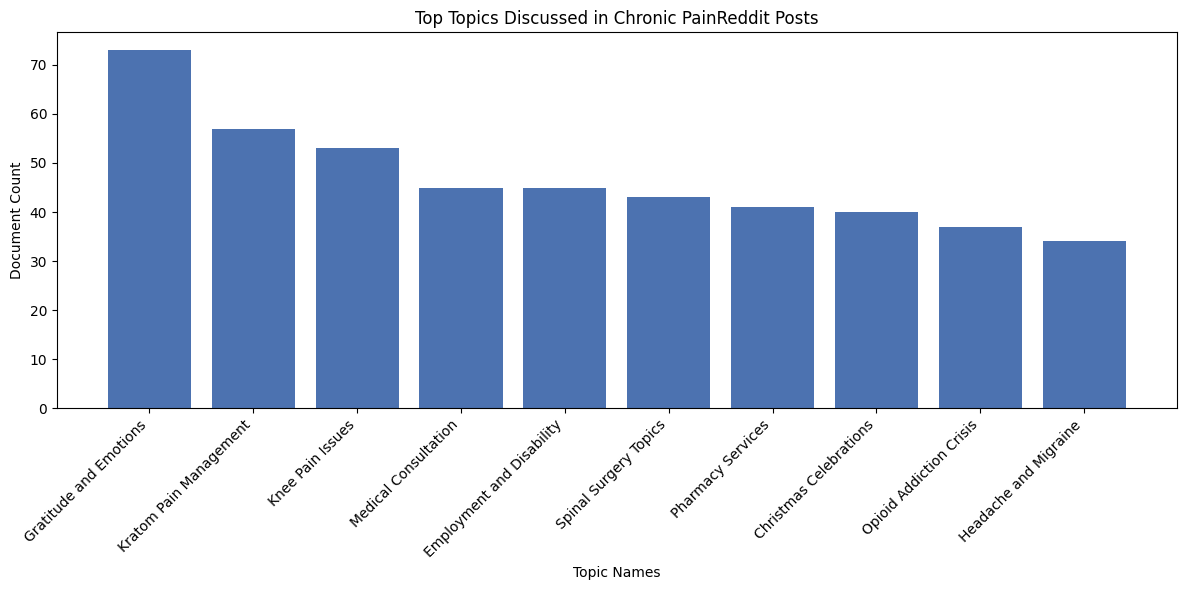

In [75]:
# Modify your visualization to use topic names
def plot_top_topics_with_names(topic_model, topic_names, n_topics=10):
    """
    Create a bar chart of top topics with their generated names.
    Excludes the outlier topic (-1).
    """
    topic_info = topic_model.get_topic_info()
    topic_info = topic_info[topic_info['Topic'] != -1].head(n_topics)

    plt.figure(figsize=(12, 6))
    plt.bar(
        range(len(topic_info)),
        topic_info['Count'],
        tick_label=[topic_names.get(t, 'Topic '+ str(t)) for t in topic_info['Topic']]
    )
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Topic Names')
    plt.ylabel('Document Count')
    plt.title('Top Topics Discussed in Chronic PainReddit Posts')
    plt.tight_layout()
    plt.show()

plot_top_topics_with_names(topic_model, topic_names)

In [46]:
fig = topic_model.visualize_topics(width=1000)

fig.show()

In [47]:
fig = topic_model.visualize_hierarchy()
fig.show()

In [170]:
# First, set the custom labels
topic_model.set_topic_labels(topic_names)

# Then visualize with custom labels enabled
fig = topic_model.visualize_hierarchy(
    custom_labels=True,
    title="Topic Hierarchy in Chronic Pain Reddit Discussions",
    width=800,  # Increase width for better readability
    height=1600   # Increase height for better spacing
)

# Update the layout with larger font sizes
fig.update_layout(
    font=dict(size=14),
    title=dict(
        font=dict(size=24, weight='bold'),
        x=0.5,  # Center the title
        xanchor='center'
    ),
)

cluster_colors = {
    'cluster1': '#2ecc71',  # green
    'cluster2': '#e74c3c',  # red
    'cluster3': '#3498db'   # light blue
}

# Update axis labels font size
fig.update_xaxes(tickfont=dict(size=16))
fig.update_yaxes(tickfont=dict(size=19))

# update the x label 
fig.update_xaxes(title_text='Dissimilarity', title_font=dict(size=20))

# save figure
fig.show()


In [65]:
fig = topic_model.visualize_heatmap(custom_labels=True)
fig.show()

In [66]:
fig = topic_model.visualize_barchart(top_n_topics=10)
fig.show()

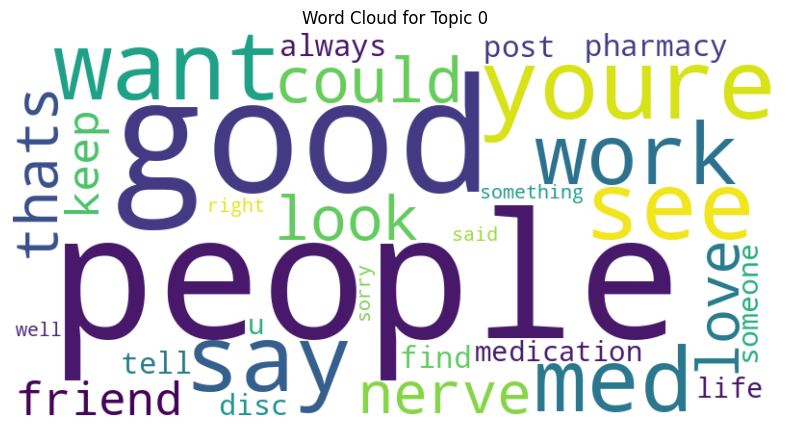

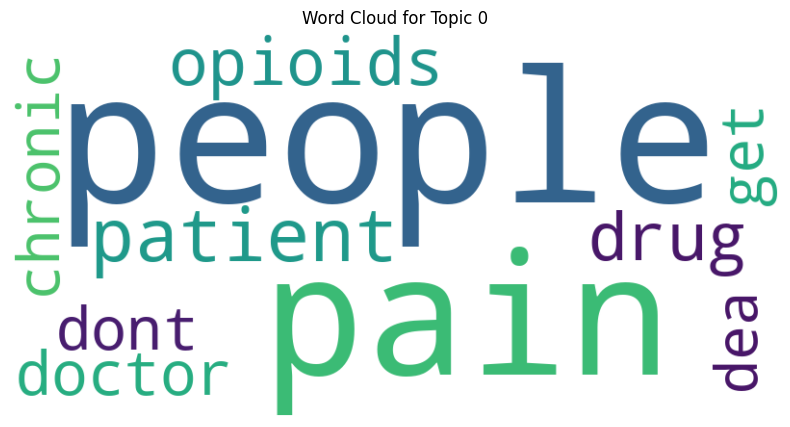

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud_for_topic(topic_id, model, num_words=30):
    """
    Generates a word cloud for a specific topic.

    Args:
        topic_id: The ID of the topic.
        model: The trained LDA or BERTopic model.
        num_words: The number of top words to include in the word cloud.
    """

    if isinstance(model, LdaModel):
        # For Gensim LDA model
        words = dict(model.show_topic(topic_id, num_words))
    elif isinstance(model, BERTopic):
        # For BERTopic model
        words = {word: prob for word, prob in model.get_topic(topic_id)}
    else:
        raise ValueError("Unsupported model type")

    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(words)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Topic {topic_id}")
    plt.show()

# Example usage with LDA:
create_wordcloud_for_topic(0, lda_model)  # Create a word cloud for topic 0

# Example usage with BERTopic:
create_wordcloud_for_topic(0, topic_model)  # Create a word cloud for topic 0

In [124]:
topic_clusters = {
    "daily_life_and_emotional": [
        "Dreaming and Sleep",
        "Daily Struggles",
        "Christmas Celebrations",
        "Emotional Turmoil",
        "Employment and Disability",
        "Gratitude and Emotions",
        "Chronic Pain Experience",
        "Chronic Relationship Struggles",
        "Emotional Well-being",
        "Emotional Reflection",
        "Pain Measurement",
        "Mobility Aids",
        "Dog Love"
    ],
    "medical_care_and_treatment": [
        "Pharmacy Services",
        "Medical Care Services",
        "Medical Consultation",
        "Pain Management",
        "Opioid Addiction Crisis",
        "Kratom Pain Management",
        "Healthcare and Insurance",
        "Gabapentin Dosage Effects",
        "Cannabis and Relief"
    ],
    "specific_conditions_and_techniques": [
        "Abdominal Surgery Issues",
        "Pain Management Techniques",
        "Pelvic Pain Management",
        "Knee Pain Issues",
        "Spinal Surgery Topics",
        "Headache and Migraine",
        "Chronic Illness Symptoms",
        "Neck Muscle Tension",
        "Healthy Eating Habits"
    ]
}

Batches:   0%|          | 0/56 [00:00<?, ?it/s]

2025-01-22 11:00:25,400 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-01-22 11:00:25,405 - BERTopic - Dimensionality - Completed ✓
2025-01-22 11:00:25,406 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-01-22 11:00:25,427 - BERTopic - Cluster - Completed ✓


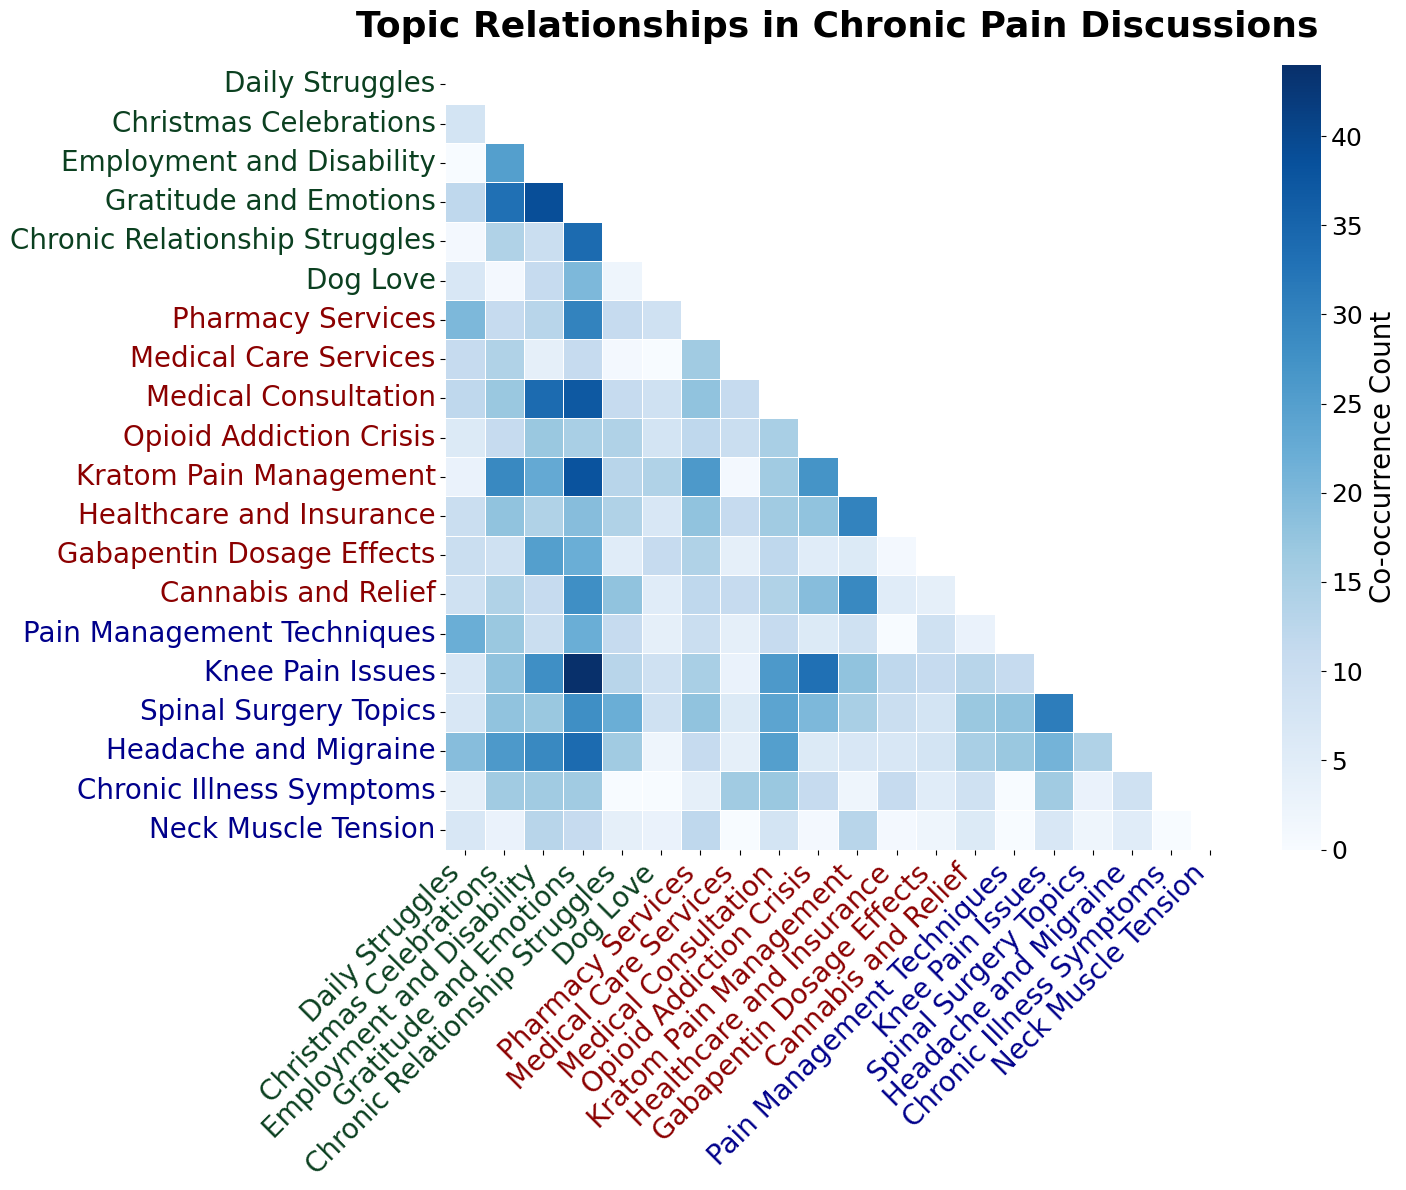

In [152]:
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def create_topic_cooccurrence_matrix(topic_model, docs, n_topics=20, custom_labels=None):
    """
    Create a topic co-occurrence matrix based on document-topic predictions.
    
    Args:
        topic_model: Fitted BERTopic model
        docs: Original documents
        n_topics: Number of top topics to include
        custom_labels: A dictionary mapping topic IDs to custom labels. If None, default labels are used.
    """
    # Get topic predictions
    topics = topic_model.transform(docs)[0]  # Only take the topics, not the probabilities
    
    # Get top N topics (excluding -1 if it exists)
    topic_freq = topic_model.get_topic_freq()
    top_topics = topic_freq[topic_freq['Topic'] != -1]['Topic'].head(n_topics).tolist()
    
    # Initialize co-occurrence matrix
    cooc_matrix = np.zeros((len(top_topics), len(top_topics)))
    
    # Create a sliding window to look for co-occurrences
    window_size = 5  # Adjust this value as needed
    for i in range(len(topics) - window_size + 1):
        window_topics = topics[i:i + window_size]
        # Get unique topics in the window that are in our top topics
        window_topics = [t for t in set(window_topics) if t in top_topics]
        
        # Count co-occurrences
        for t1, t2 in itertools.combinations(window_topics, 2):
            if t1 in top_topics and t2 in top_topics:
                i = top_topics.index(t1)
                j = top_topics.index(t2)
                cooc_matrix[i, j] += 1
                cooc_matrix[j, i] += 1
    
    # Create labels using topic representations or custom labels
    labels = []
    if custom_labels:
        for topic in top_topics:
            if topic in custom_labels:
                labels.append(custom_labels[topic])
            else:
                top_words = topic_model.get_topic(topic)[:3]  # Get top 3 words
                label = f"Topic {topic}\n({', '.join([word for word, _ in top_words])})"
                labels.append(label)
    else:
        for topic in top_topics:
            top_words = topic_model.get_topic(topic)[:3]  # Get top 3 words
            label = f"Topic {topic}\n({', '.join([word for word, _ in top_words])})"
            labels.append(label)
    
    return pd.DataFrame(cooc_matrix, index=labels, columns=labels)

def plot_topic_cooccurrence_heatmap(cooc_df, topic_clusters):
    """
    Plot a heatmap of the topic co-occurrence matrix with colored labels based on clusters,
    with topics ordered by cluster.
    
    Args:
        cooc_df (DataFrame): Topic co-occurrence matrix as a DataFrame
        topic_clusters (dict): Dictionary mapping cluster names to lists of topic names
    """
    # Create ordered list of topics based on clusters
    ordered_topics = []
    for cluster_name, topics in topic_clusters.items():
        # Only include topics that exist in our co-occurrence matrix
        cluster_topics = [topic for topic in topics if topic in cooc_df.index]
        ordered_topics.extend(cluster_topics)
    
    # Reorder the dataframe based on clusters
    cooc_df = cooc_df.loc[ordered_topics, ordered_topics]
    
    plt.figure(figsize=(15, 12))
    mask = np.triu(np.ones_like(cooc_df, dtype=bool))
    
    # Define colors for each cluster
    cluster_colors = {
        'daily_life_and_emotional': '#0b4020',    # darker green
        'medical_care_and_treatment': '#8b0000',  # darker red
        'specific_conditions_and_techniques': '#00008b'  # darker blue
    }
    
    # Create a mapping of topic names to their cluster colors
    topic_colors = {}
    for cluster_name, topics in topic_clusters.items():
        for topic in topics:
            topic_colors[topic] = cluster_colors[cluster_name]
    
    # Create heatmap
    ax = sns.heatmap(cooc_df,
                     mask=mask,
                     cmap='Blues',
                     square=True,
                     linewidths=0.5,
                     cbar_kws={'label': 'Co-occurrence Count'},
                     xticklabels=True,
                     yticklabels=True)
    
    cbar = ax.collections[0].colorbar
    cbar.ax.set_ylabel('Co-occurrence Count', fontsize=20)
    cbar.ax.tick_params(labelsize=18)
    
    plt.title('Topic Relationships in Chronic Pain Discussions', fontsize=26, pad=20, fontweight='bold')
    
    # Color the labels based on their clusters
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=20)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=20)
    
    # Update tick colors
    for tick in ax.get_xticklabels():
        tick_text = tick.get_text()
        tick_color = topic_colors.get(tick_text, 'black')  # Default to black if topic not found
        tick.set_color(tick_color)
    
    for tick in ax.get_yticklabels():
        tick_text = tick.get_text()
        tick_color = topic_colors.get(tick_text, 'black')  # Default to black if topic not found
        tick.set_color(tick_color)
    
    plt.tight_layout()
    plt.savefig("/Users/julienh/Desktop/McGillWork/PainLexicon/chronic_reddit_scraper/visualizations/topic_cooccurence.png", bbox_inches='tight', dpi=300)
    plt.show()

# Create and plot the matrix with colored labels and ordered topics
topic_cooc_df = create_topic_cooccurrence_matrix(topic_model, cleaned_posts_texts, n_topics=20, custom_labels=topic_names)
plot_topic_cooccurrence_heatmap(topic_cooc_df, topic_clusters)

### Dimensionality Reduction 

In [10]:
from umap import UMAP
from bertopic import BERTopic
import plotly.express as px
import pandas as pd

# Assuming you have already trained your BERTopic model (topic_model) 
# and have your cleaned_posts_texts

# Get embeddings from the topic model
embeddings = topic_model.embedding_model.embed(cleaned_posts_texts)

# 1. Reduce dimensionality with UMAP (recommended)
umap_model = UMAP(n_neighbors=15, n_components=2, metric='cosine', random_state=42)
reduced_embeddings = umap_model.fit_transform(embeddings)

# 2. Visualize reduced embeddings
# For interactive plots use visualize_documents
# topic_model.visualize_documents(docs=cleaned_posts_texts, embeddings=embeddings, reduced_embeddings=reduced_embeddings)

# For static plots you can use matplotlib:
topics = topic_model.topics_

# Prepare the data for plotting
df = pd.DataFrame({"x": reduced_embeddings[:, 0], "y": reduced_embeddings[:, 1], "topic": topics})

# Create the plot
fig = px.scatter(df, x="x", y="y", color="topic", hover_data=["topic"], title="t-SNE Visualization of Document Embeddings")

# Customize the layout
fig.update_layout(
    xaxis_title="Dimension 1",
    yaxis_title="Dimension 2",
    legend_title="Topic",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="RebeccaPurple"
    )
)

fig.show()